Weighted Edges

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

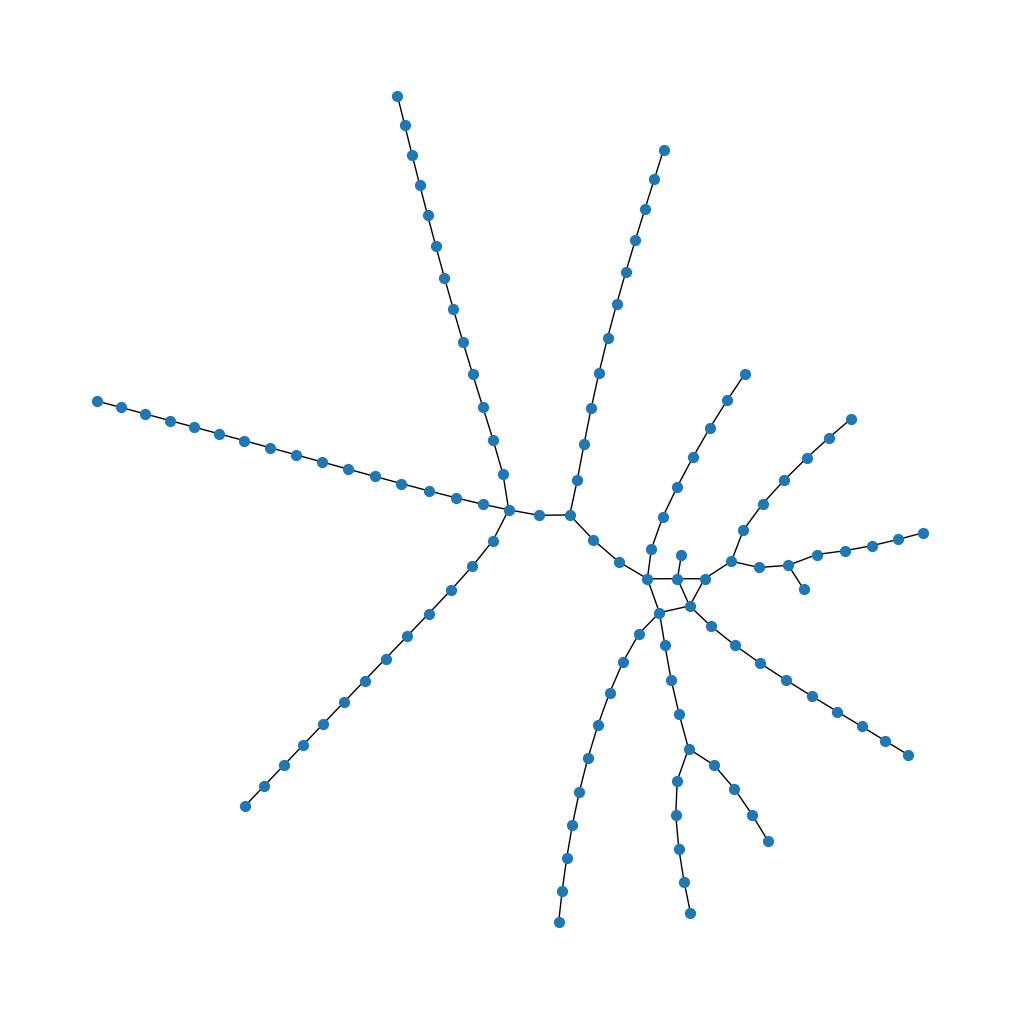

In [27]:
def open_line_file(filename):
    with open(f'../lines_from_gtfs_static_data/{filename}.txt', 'r') as f:
      lines = f.readlines()
    return lines

line_files = [
    'Red-C1-0',
    'Red-C1-1',
    'Red-C2-0',
    'Red-C2-1',
    'Green-B-C1-0',
    'Green-B-C1-1',
    'Green-C-C1-0',
    'Green-C-C1-1',
    'Green-D-C1-0',
    'Green-D-C1-1',
    'Green-E-C1-0',
    'Green-E-C1-1',
    'Orange-C1-0',
    'Orange-C1-1',
    'Blue-C1-0',
    'Blue-C1-1'
]

line_stations = map(open_line_file, line_files)

stations = set()
edges = set()

for line in line_stations:
    for i in range(len(line)-1):
        stop_name = line[i].rstrip()
        next_stop_name = line[i+1].rstrip()
        stations.add(stop_name)
        edges.add((stop_name, next_stop_name))
    end_stop_name = line[-1].rstrip()
    stations.add(end_stop_name)

network = nx.Graph()
network.add_nodes_from(stations)
network.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)
nx.draw(network, layout, node_size=50)

Getting the weights

In [28]:
import json


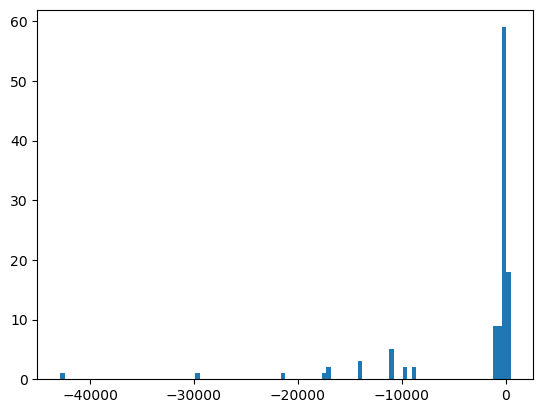

In [29]:
delays_file = open("../delay_data/named_rapid_transit_delays.json", 'r')
delays_json = delays_file.read()
delays_file.close()

delays = json.loads(delays_json)
fig, ax = plt.subplots()
hist = ax.hist(delays.values(), bins=100)

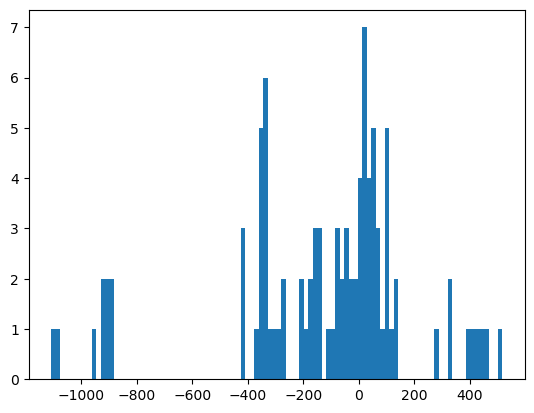

In [30]:
# remove outliers
delays = dict((s, d) for s, d in delays.items() if d > -5000)

fig, ax = plt.subplots()
hist = ax.hist(delays.values(), bins=100)

In [31]:
nx.set_node_attributes(network, delays, "avg_delay")


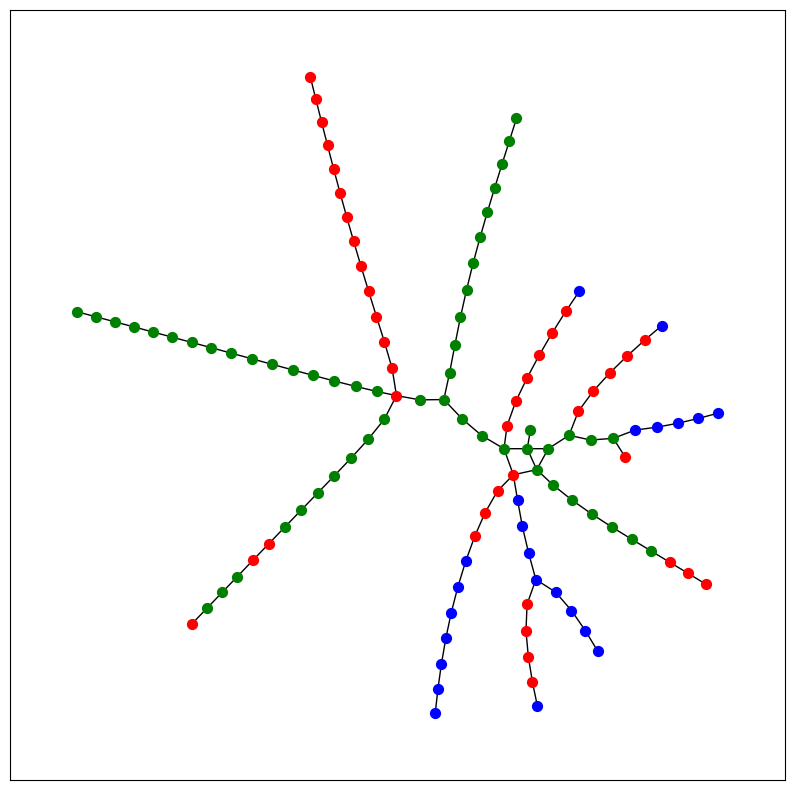

In [32]:
# proof of concept for coloring nodes; for now just split into positive and negative delays
# later we can split into bins
nonnegative_delay_nodes = [n for (n, delay) in nx.get_node_attributes(network, "avg_delay").items() if delay >= 0]
negative_delay_nodes = [n for (n, delay) in nx.get_node_attributes(network, "avg_delay").items() if delay < 0]
remaining_nodes = list(set(network.nodes()) - set(nonnegative_delay_nodes) - set(negative_delay_nodes))

fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)
nx.draw_networkx_nodes(network, layout, nodelist=nonnegative_delay_nodes, node_color='red', node_size=50)
nx.draw_networkx_nodes(network, layout, nodelist=negative_delay_nodes, node_color='green', node_size=50)
nx.draw_networkx_nodes(network, layout, nodelist=remaining_nodes, node_color='blue', node_size=50)
nx.draw_networkx_edges(network, layout)

In [45]:
test_avg_edge_weight = sum(delays.values()) / len(delays) 
test_avg_edge_weight

-133.71152882205513

In [50]:
# Create our attribute_dict
dict_of_delay = nx.get_node_attributes(network, "avg_delay")

def get_delay(node_name, attribute_dict = dict_of_delay):
    try:
      attribute_val = attribute_dict[node_name]
    except:
      attribute_val = 0
    return attribute_val

In [ ]:
def normalize_graph(G):
    
    # Get list of old edge weights
    old_edge_weights = [data['weight'] for node1, node2, data in G.edges(data=True)]
    # Calculate mean of old edge weights
    mean_old_edge_weights = sum(old_edge_weights)/len(old_edge_weights)
    
    # importing Statistics module
    import statistics
    # Calculate standard deviation of old edge weights
    stdev_old_edge_weights = statistics.stdev(old_edge_weights)
    
    # Create new graph we will add edges to 
    new_G = nx.Graph()
    new_G.add_nodes_from(list(G))
    for node1, node2, data in G.edges(data=True):
        # Z-score
        std_weight = (data['weight'] - mean_old_edge_weights)/stdev_old_edge_weights
        # New standard deviation of: std_weight/5
        std_weight = std_weight/5
        # New mean of 1
        std_weight = std_weight + 1

        # if less than 0, turn to 0
        if std_weight < 0:
            std_weight = 0
            
        # Add new weights to new graph
        new_G.add_edge(node1, node2, weight = std_weight)
        
    return new_G
        